DenseNet é uma arquitetura de rede neural convolucional que foi desenvolvida para resolver o problema de desaparecimento de gradiente. A ideia principal é conectar todas as camadas de uma rede em vez de apenas as camadas adjacentes. Isso permite que o gradiente flua diretamente para camadas anteriores, o que ajuda a resolver o problema de desaparecimento de gradiente.


In [1]:
# Loading the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import cv2
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

In [2]:
def load_images(path):

    X = []
    y = []

    for folder in os.listdir(path):
        files = os.listdir(path + folder)
        for file in tqdm(files):
            img = cv2.imread(path + folder + '/' + file)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(folder)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

train_path = '../data/seg_train/'
test_path = '../data/seg_test/'

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

classes_names = np.unique(y_train)

# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One hot encoding the target variable
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

# Splitting the training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=0)

# Normalizing the images
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

100%|██████████| 501/501 [00:04<00:00, 103.31it/s]


In [3]:
# building the model
# os pesos são os pesos da rede pré-treinada 
dense_net = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = dense_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)


model = Model(inputs=dense_net.input, outputs=predictions)

for layer in dense_net.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1/conv[0][0]']         

In [5]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
351/351 [==============================] - 387s 1s/step - loss: 0.5448 - accuracy: 0.7962 - val_loss: 0.3550 - val_accuracy: 0.8721
Epoch 2/30
351/351 [==============================] - 412s 1s/step - loss: 0.3572 - accuracy: 0.8693 - val_loss: 0.3412 - val_accuracy: 0.8778
Epoch 3/30
351/351 [==============================] - 312s 889ms/step - loss: 0.3201 - accuracy: 0.8863 - val_loss: 0.3260 - val_accuracy: 0.8824
Epoch 4/30
351/351 [==============================] - 301s 857ms/step - loss: 0.2939 - accuracy: 0.8940 - val_loss: 0.3151 - val_accuracy: 0.8888
Epoch 5/30
351/351 [==============================] - 259s 739ms/step - loss: 0.2728 - accuracy: 0.9018 - val_loss: 0.3313 - val_accuracy: 0.8888
Epoch 6/30
351/351 [==============================] - 258s 736ms/step - loss: 0.2559 - accuracy: 0.9055 - val_loss: 0.3288 - val_accuracy: 0.8849
Epoch 7/30
351/351 [==============================] - 251s 715ms/step - loss: 0.2484 - accuracy: 0.9101 - val_loss: 0.3185 - val_a

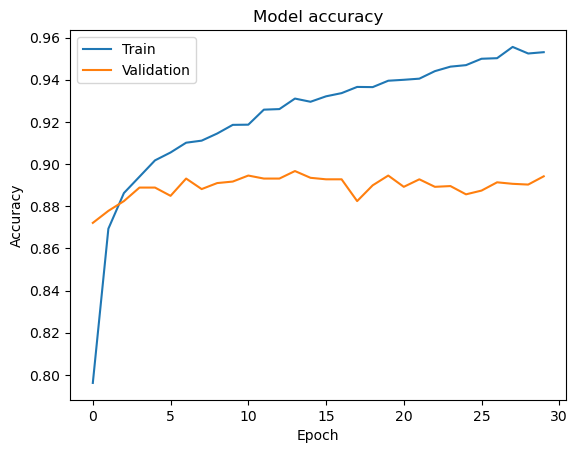

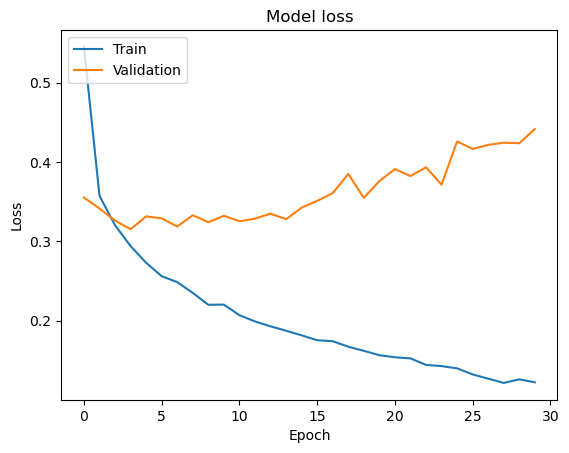

In [6]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


94/94 [==============================] - 54s 575ms/step - loss: 0.3748 - accuracy: 0.9007
F1 Score:  0.9003663938767804
Precision:  0.9007372885968373
Recall:  0.9006666666666666
Accuracy:  0.9006666666666666
Loss:  0.374765008687973
Test Set Evaluation Metrics


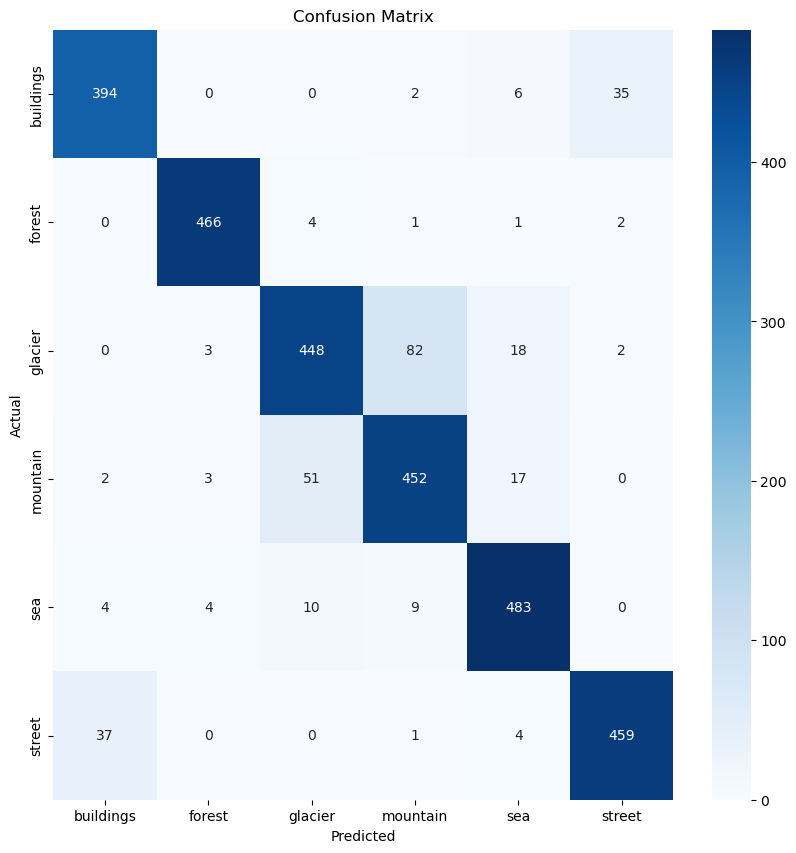

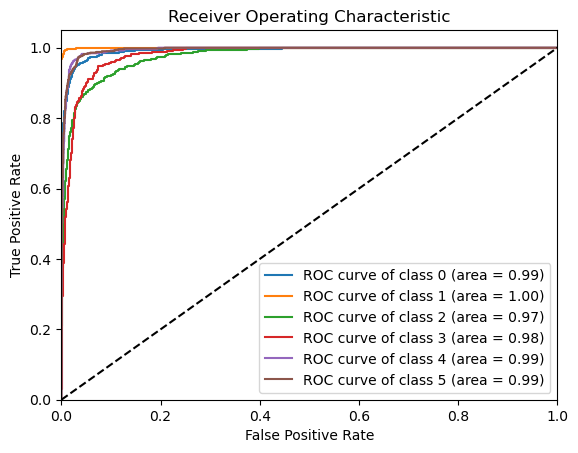

In [7]:
from sklearn.metrics import f1_score,confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, auc

predictions = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, y_test_encoded)

y_pred = np.argmax(predictions, axis=1)
y_test = np.argmax(y_test_encoded, axis=1)

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

confusion_matrix = confusion_matrix(y_test, y_pred)
print('F1 Score: ', f1)
print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('Loss: ', loss)

print('Test Set Evaluation Metrics')
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 6

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

